# Uploading data sets

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

uploaded = ['/content/drive/My Drive/Images.zip',
            '/content/drive/My Drive/Data-split.zip',
            '/content/drive/My Drive/LUNA.zip']

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#from google.colab import files

#uploaded = files.upload()

#for f in uploaded:
#    print('Uploaded: ' + f)

In [ ]:
from zipfile import ZipFile

for f in uploaded:
    with ZipFile(f, 'r') as zip_ref:
        zip_ref.extractall('.')

# SSL on LUNA

In [ ]:
import os

os.mkdir('ssl1_backup')
os.mkdir('ssl1_result')

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet169 as DenseNet169
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch.nn.functional as F

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
rng = np.random.RandomState(42)

In [ ]:
torch.cuda.empty_cache()

device = 'cuda'
batchsize = 16
train_epochs_start = 0
train_epochs_end = 50

In [ ]:
class SimCLR(nn.Module):

    def __init__(self, out_dim=128):
        super(SimCLR, self).__init__()

        densenet = DenseNet169(pretrained=False)
        self.features = densenet.features
        self.relu = nn.ReLU(inplace=True)
        # MLP head
        self.classifier = nn.Sequential(
            nn.Linear(
                densenet.classifier.in_features,
                densenet.classifier.in_features,
                bias=True
            ),
            nn.ReLU(),
            nn.Linear(
                densenet.classifier.in_features,
                out_features=out_dim,
                bias=True
            )
        )

    def forward(self, x):
        out = self.features(x)
        out = self.relu(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
class NTXentLoss(nn.Module):

    def __init__(self):
        super(NTXentLoss, self).__init__()
        self.masks = dict()
        self.similarity_function = torch.nn.CosineSimilarity(dim=-1)
        self.criterion = torch.nn.CrossEntropyLoss()

    @staticmethod
    def get_mask(batch_size):
        diag = np.eye(2 * batch_size)
        l1 = np.eye(2 * batch_size, k=-batch_size)
        l2 = np.eye(2 * batch_size, k=batch_size)
        mask = torch.from_numpy(diag + l1 + l2)
        mask = (1 - mask).type(torch.bool)
        return mask.to(device)

    def forward(self, zi, zj, temperature=0.5):

        batch_size = zi.shape[-2]
        if batch_size not in self.masks:
            self.masks[batch_size] = NTXentLoss.get_mask(batch_size)

        representations = torch.cat([zi, zj], dim=0)

        similarity_matrix = self.similarity_function(
            representations.unsqueeze(1),
            representations.unsqueeze(0)
        )

        # filter out the scores from the positive samples
        l_pos = torch.diag(similarity_matrix, batch_size)
        r_pos = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([l_pos, r_pos]).view(2 * batch_size, 1)

        negatives = similarity_matrix[self.masks[batch_size]].view(2 * batch_size, -1)

        logits = torch.cat([positives, negatives], dim=1)
        logits /= temperature

        labels = torch.zeros(2 * batch_size).to(device).long()
        loss = self.criterion(logits, labels)
        return loss

In [ ]:
model = SimCLR()
if device == 'cuda':
    model = model.cuda()
modelname = 'SimCLR'

if train_epochs_start > 0:
    model.load_state_dict(
        torch.load('ssl_backup/{}_{}.pt'.format(
            modelname,
            train_epochs_start
        ))
    )

In [ ]:
stages = ['ssl1', 'ssl2', 'fine-tuning']
stage_id = 0

def plot_change(model1, model2):
    global stage_id

    diff = torch.nn.MSELoss()
    norm_w, norm_wx, norm_b, norm_bx, conv_w, conv_wx = [], [], [], [], [], []
    i = 0
    for (name, parameter1), parameter2 in  zip(model1.named_parameters(), model2.parameters()):
        name = name.split(".")
        if name[-2][:4] == "conv":
            if name[-1] == "weight":
                conv_w.append(diff(parameter1, parameter2).item())
                conv_wx.append(i)
        elif name[-2][:4] == "norm":
            if name[-1] == "weight":
                norm_w.append(diff(parameter1, parameter2).item())
                norm_wx.append(i)
            elif name[-1] == "bias":
                norm_b.append(diff(parameter1, parameter2).item())
                norm_bx.append(i)
        i = i + 1

    plt.bar(norm_wx, norm_w, label="gamma")
    plt.bar(norm_bx, norm_b, label="beta")
    plt.legend()
    plt.title('Change of parameters at BN layers')
    plt.savefig(stages[stage_id] + '_bn_change.png')
    plt.show()

    plt.bar(conv_wx, conv_w)
    plt.title('Change of weights at CONV layers')
    plt.savefig(stages[stage_id] + '_conv_change.png')
    plt.show()

    stage_id = stage_id + 1

In [ ]:
model_old = SimCLR()
model_old.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
from PIL import ImageFilter
import random

class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [ ]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
transformer = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

In [ ]:
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class LUNADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
            Args:
                txt_path (string): Path to the txt file with annotations.
                root_dir (string): Directory with all the images.
                transform (callable, optional): Optional transform to be applied on a sample.
            File structure:
                - LUNA
                    - img1.png
                    - img2.png
                    - ......
        """
        self.img_list = [os.path.join(root_dir, item) for item in os.listdir(root_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx]
        image = Image.open(img_path).convert('RGB')

        image0 = self.transform(image)
        image1 = self.transform(image)

        sample = {'img0': image0, 'img1': image1}
        return sample

In [ ]:
dataset = LUNADataset(
    root_dir='LUNA',
    transform=transformer
)
print("dataset length:", dataset.__len__())
data_loader = DataLoader(dataset, batch_size=batchsize, drop_last=False, shuffle=True)

dataset length: 1000


In [ ]:
def train(epoch):

    model.train()

    train_loss = 0

    for batch_index, batch_samples in enumerate(data_loader):

        # move data to device
        data0, data1 = batch_samples['img0'].to(device), batch_samples['img1'].to(device)

        output0 = model(data0)
        output1 = model(data1)

        loss = criteria(output0, output1)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Display progress
        if (batch_index + 1) % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch,
                batch_index, len(data_loader),
                100.0 * batch_index / len(data_loader)
            ))

    avg_loss = train_loss / len(data_loader.dataset)
    print('Data set: Average loss: {:.4f}'.format(avg_loss))
    f = open('ssl1_result/train_{}.txt'.format(modelname), 'a+')
    f.write('Data set: Average loss: {:.4f}'.format(avg_loss))
    f.close()
    avg_losses.append(avg_loss)

In [ ]:
bs = 10
T_checkpoint = 10
avg_losses = []

criteria = NTXentLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(train_epochs_start + 1, train_epochs_end + 1):
    train(epoch)
    
    if epoch % T_checkpoint == 0:
        # checkpoint
        torch.save(model.state_dict(), 'ssl1_backup/{}_{}.pt'.format(modelname, epoch))

Train Epoch: 1 [9/63 (14%)]
Train Epoch: 1 [19/63 (30%)]
Train Epoch: 1 [29/63 (46%)]
Train Epoch: 1 [39/63 (62%)]
Train Epoch: 1 [49/63 (78%)]
Train Epoch: 1 [59/63 (94%)]
Data set: Average loss: 0.2032
Train Epoch: 2 [9/63 (14%)]
Train Epoch: 2 [19/63 (30%)]
Train Epoch: 2 [29/63 (46%)]
Train Epoch: 2 [39/63 (62%)]
Train Epoch: 2 [49/63 (78%)]
Train Epoch: 2 [59/63 (94%)]
Data set: Average loss: 0.1939
Train Epoch: 3 [9/63 (14%)]
Train Epoch: 3 [19/63 (30%)]
Train Epoch: 3 [29/63 (46%)]
Train Epoch: 3 [39/63 (62%)]
Train Epoch: 3 [49/63 (78%)]
Train Epoch: 3 [59/63 (94%)]
Data set: Average loss: 0.1814
Train Epoch: 4 [9/63 (14%)]
Train Epoch: 4 [19/63 (30%)]
Train Epoch: 4 [29/63 (46%)]
Train Epoch: 4 [39/63 (62%)]
Train Epoch: 4 [49/63 (78%)]
Train Epoch: 4 [59/63 (94%)]
Data set: Average loss: 0.1774
Train Epoch: 5 [9/63 (14%)]
Train Epoch: 5 [19/63 (30%)]
Train Epoch: 5 [29/63 (46%)]
Train Epoch: 5 [39/63 (62%)]
Train Epoch: 5 [49/63 (78%)]
Train Epoch: 5 [59/63 (94%)]
Data set: A

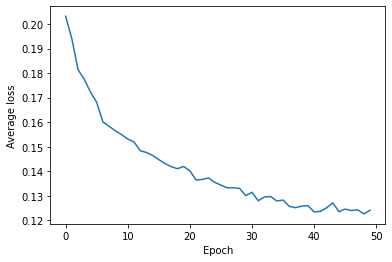

In [ ]:
plt.plot(range(train_epochs_start, train_epochs_end), avg_losses)
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.savefig('ssl1_loss.png')
plt.show()

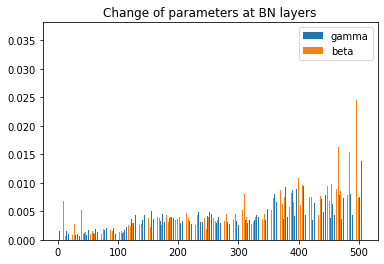

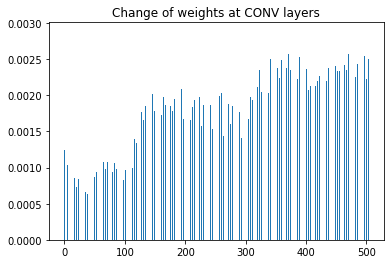

In [ ]:
plot_change(model.cpu(), model_old)

In [ ]:
torch.save(model.state_dict(), 'ssl1.pt')

# SSL on COVID-CT

In [ ]:
os.mkdir('ssl2_backup')
os.mkdir('ssl2_result')

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
rng = np.random.RandomState(42)

In [ ]:
torch.cuda.empty_cache()

device = 'cuda'
batchsize = 16
train_epochs_start = 0
train_epochs_end = 50
ssl1_epochs = 50

In [ ]:
model = SimCLR()
modelname = 'SimCLR'

if train_epochs_start > 0:
    model.load_state_dict(
        torch.load('ssl2_backup/{}_{}.pt'.format(
            modelname,
            train_epochs_start
        ))
    )
else:
    model.load_state_dict(
        torch.load('ssl1_backup/{}_{}.pt'.format(
            modelname,
            ssl1_epochs
        ))
    )

if device == 'cuda':
    model = model.cuda()

In [ ]:
model_old = SimCLR()
model_old.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
transformer = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

In [ ]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=transformer):
        """
            Args:
                txt_path (string): Path to the txt file with annotations.
                root_dir (string): Directory with all the images.
                transform (callable, optional): Optional transform to be applied on a sample.
            File structure:
                - root_dir
                    - CT_COVID
                        - img1.png
                        - img2.png
                        - ......
                    - CT_NonCOVID
                        - img1.png
                        - img2.png
                        - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID, txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [os.path.join(self.root_dir, self.classes[c], item) for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx]
        image = Image.open(img_path).convert('RGB')

        image0 = self.transform(image)
        image1 = self.transform(image)

        sample = {'img0': image0, 'img1': image1}
        return sample

In [ ]:
dataset = CovidCTDataset(
    root_dir='Images',
    txt_COVID='Data-split/COVID/trainCT_COVID.txt',
    txt_NonCOVID='Data-split/NonCOVID/trainCT_NonCOVID.txt',
    transform=transformer
)
print("dataset length:", dataset.__len__())
data_loader = DataLoader(dataset, batch_size=batchsize, drop_last=False, shuffle=True)

dataset length: 425


In [ ]:
def train(epoch):

    model.train()

    train_loss = 0

    for batch_index, batch_samples in enumerate(data_loader):

        # move data to device
        data0, data1 = batch_samples['img0'].to(device), batch_samples['img1'].to(device)

        output0 = model(data0)
        output1 = model(data1)

        loss = criteria(output0, output1)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Display progress
        if (batch_index + 1) % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch,
                batch_index, len(data_loader),
                100.0 * batch_index / len(data_loader)
            ))

    avg_loss = train_loss / len(data_loader.dataset)
    print('Data set: Average loss: {:.4f}'.format(avg_loss))
    f = open('ssl2_result/train_{}.txt'.format(modelname), 'a+')
    f.write('Data set: Average loss: {:.4f}'.format(avg_loss))
    f.close()
    avg_losses.append(avg_loss)

In [ ]:
bs = 10
T_checkpoint = 10
avg_losses = []

criteria = NTXentLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(train_epochs_start + 1, train_epochs_end + 1):
    train(epoch)
    
    if epoch % T_checkpoint == 0:
        # checkpoint
        torch.save(model.state_dict(), 'ssl2_backup/{}_{}.pt'.format(modelname, epoch))

Train Epoch: 1 [9/27 (33%)]
Train Epoch: 1 [19/27 (70%)]
Data set: Average loss: 0.1528
Train Epoch: 2 [9/27 (33%)]
Train Epoch: 2 [19/27 (70%)]
Data set: Average loss: 0.1489
Train Epoch: 3 [9/27 (33%)]
Train Epoch: 3 [19/27 (70%)]
Data set: Average loss: 0.1427
Train Epoch: 4 [9/27 (33%)]
Train Epoch: 4 [19/27 (70%)]
Data set: Average loss: 0.1393
Train Epoch: 5 [9/27 (33%)]
Train Epoch: 5 [19/27 (70%)]
Data set: Average loss: 0.1369
Train Epoch: 6 [9/27 (33%)]
Train Epoch: 6 [19/27 (70%)]
Data set: Average loss: 0.1384
Train Epoch: 7 [9/27 (33%)]
Train Epoch: 7 [19/27 (70%)]
Data set: Average loss: 0.1383
Train Epoch: 8 [9/27 (33%)]
Train Epoch: 8 [19/27 (70%)]
Data set: Average loss: 0.1329
Train Epoch: 9 [9/27 (33%)]
Train Epoch: 9 [19/27 (70%)]
Data set: Average loss: 0.1367
Train Epoch: 10 [9/27 (33%)]
Train Epoch: 10 [19/27 (70%)]
Data set: Average loss: 0.1338
Train Epoch: 11 [9/27 (33%)]
Train Epoch: 11 [19/27 (70%)]
Data set: Average loss: 0.1352
Train Epoch: 12 [9/27 (33%)]

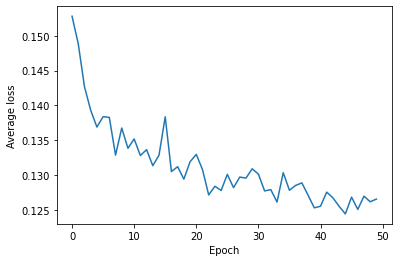

In [ ]:
plt.plot(range(train_epochs_start, train_epochs_end), avg_losses)
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.savefig('ssl2_loss.png')
plt.show()

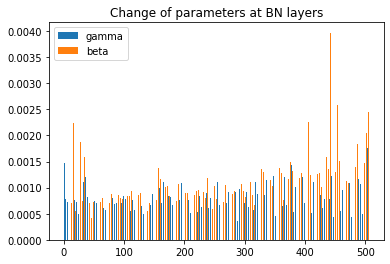

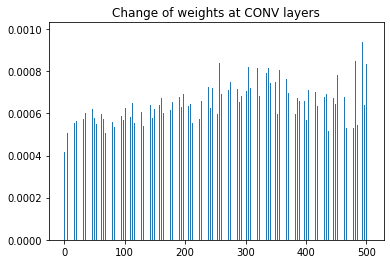

In [ ]:
plot_change(model.cpu(), model_old)

In [ ]:
torch.save(model.state_dict(), 'ssl2.pt')

# Fine-tuning the model on the final task

In [ ]:
os.mkdir('model_backup')
os.mkdir('model_result')

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
rng = np.random.RandomState(42)

In [ ]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

torch.cuda.empty_cache()


batchsize = 16
train_epochs_start = 0
train_epochs_end = 50
ssl2_epochs = 50

In [ ]:
class FineTune(torch.nn.Module):
    def __init__(self, ssl_model, out_dim=2):
        super(FineTune, self).__init__()

        self.features = ssl_model.features
        self.relu = nn.ReLU(inplace=True)
        self.classifier = nn.Linear(
            ssl_model.classifier[0].in_features,
            out_features=out_dim,
            bias=True
        )

    def forward(self, x):
        out = self.features(x)
        out = self.relu(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

In [ ]:
model = SimCLR()
modelname = 'SimCLR'

if train_epochs_start > 0:
    model = FineTune(model)
    modelname = 'FineTune'
    model.load_state_dict(
        torch.load('model_backup/{}_{}.pt'.format(
            modelname,
            train_epochs_start
        ))
    )
else:
    model.load_state_dict(
        torch.load('ssl2_backup/{}_{}.pt'.format(
            modelname,
            ssl2_epochs
        ))
    )
    model = FineTune(model)
    modelname = 'FineTune'

if device == 'cuda':
    model = model.cuda()

In [ ]:
model_old = FineTune(SimCLR())
model_old.load_state_dict(model.state_dict())

<All keys matched successfully>

In [ ]:
normalize = transforms.Normalize(
    mean=[0.45271412, 0.45271412, 0.45271412],
    std=[0.33165374, 0.33165374, 0.33165374]
)
train_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

detransformer = torchvision.transforms.Compose([
    lambda image_tensor : image_tensor * torch.tensor([0.33165374, 0.33165374, 0.33165374])[:, None, None],
    lambda image_tensor : image_tensor + torch.tensor([0.45271412, 0.45271412, 0.45271412])[:, None, None],
    torchvision.transforms.ToPILImage()
])

In [ ]:
def gradcam(model, input_tensor, detransform, label, axis):

	# Activations are saved.
	activations = dict() # one-key dictionary. Doesn't work otherwise.
	def get_activations(name):
		def hook(module, input, output):
			activations[name] = output.detach()
		return hook

	# Gradients are saved.
	grads = dict() # same as for activations
	def get_grads(name):
		def hook(module, grad_input, grad_output):
			grads[name] = grad_output[0].detach() # is a tuple
		return hook

	input_batch = input_tensor.unsqueeze(0) # a batch of one

	frw_handle = model.relu.register_forward_hook(get_activations("features"))
	bck_handle = model.relu.register_backward_hook(get_grads("features"))

	model.eval()
	model.zero_grad()
	output_batch = model(input_batch)
	output_batch[0][label].backward()

	frw_handle.remove()
	bck_handle.remove()

	activations = activations["features"]
	grads = grads["features"]

	grads = torch.mean(grads, dim=(-2, -1), keepdims=True) # gradients are pooled
	grad_cam = activations * grads
	grad_cam = torch.sum(grad_cam, dim=-3) # weighted sum
	grad_cam = torch.nn.functional.relu(grad_cam) # relu'd weighted sum
	grad_cam = grad_cam / grad_cam.max() # normalization
	grad_cam = grad_cam[0] # squeezing the batch of one

	axis.imshow(detransform(input_tensor).resize((224, 224)), alpha=1.0)
	# Grad-CAM is resized to 224x224 via bilinear interpolation and mapped to 'JET' colormap to be superimposed on the original image.
	axis.imshow(torchvision.transforms.ToPILImage()(grad_cam).resize((224, 224), resample=Image.BILINEAR), cmap='jet', alpha=0.5)
	axis.set_xticks([])
	axis.set_yticks([])

In [ ]:
# This definition overrides the previous one
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
            Args:
                txt_path (string): Path to the txt file with annotations.
                root_dir (string): Directory with all the images.
                transform (callable, optional): Optional transform to be applied on a sample.
            File structure:
                - root_dir
                    - CT_COVID
                        - img1.png
                        - img2.png
                        - ......
                    - CT_NonCOVID
                        - img1.png
                        - img2.png
                        - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID, txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir, self.classes[c], item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image, 'label': int(self.img_list[idx][1])}
        return sample

In [ ]:
trainset = CovidCTDataset(
    root_dir='Images',
    txt_COVID='Data-split/COVID/trainCT_COVID.txt',
    txt_NonCOVID='Data-split/NonCOVID/trainCT_NonCOVID.txt',
    transform=train_transformer
)
valset = CovidCTDataset(
    root_dir='Images',
    txt_COVID='Data-split/COVID/valCT_COVID.txt',
    txt_NonCOVID='Data-split/NonCOVID/valCT_NonCOVID.txt',
    transform=val_transformer
)
testset = CovidCTDataset(
    root_dir='Images',
    txt_COVID='Data-split/COVID/testCT_COVID.txt',
    txt_NonCOVID='Data-split/NonCOVID/testCT_NonCOVID.txt',
    transform=val_transformer
)
print("trainset length:", trainset.__len__())
print("valset length:", valset.__len__())
print("testset length:", testset.__len__())

train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

trainset length: 425
valset length: 118
testset length: 203


In [ ]:
def train(epoch):
        
    model.train()
        
    train_loss = 0
    train_correct = 0
        
    for batch_index, batch_samples in enumerate(train_loader):
                
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)

        output = model(data)
        loss = criteria(output, target.long())
        train_loss += loss.item()
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1)
        train_correct += (pred == target).sum().item()
        
        # Display progress
        if (batch_index + 1) % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch,
                batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader),
                train_loss / bs
            ))
            train_loss = 0
        
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = 100.0 * train_correct / len(train_loader.dataset)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss,
        train_correct, len(train_loader.dataset),
        accuracy
    ))
    f = open('model_result/train_{}.txt'.format(modelname), 'a+')
    f.write('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss,
        train_correct, len(train_loader.dataset),
        accuracy
    ))
    f.close()
    avg_losses.append(avg_loss)

In [ ]:
 def predict(mode):
    '''
        mode:
            either 'val' or 'train'
    '''
    loader = val_loader if mode == 'val' else test_loader
        
    model.eval()

    predlist=[]
    scorelist=[]
    targetlist=[]
        
    # Don't update model
    with torch.no_grad():
        # Predict
        for batch_index, batch_samples in enumerate(loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            output = model(data)
                        
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1)

            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1]) # percentages for positive
            targetlist=np.append(targetlist, targetcpu)
                                  
    return targetlist, scorelist, predlist

In [ ]:
bs = 10
votenum = 5
epochs, rs, ps, F1s, accs, AUCs = [], [], [], [], [], []
avg_losses = []

vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(train_epochs_start + 1, train_epochs_end + 1):
    train(epoch)

    targetlist, scorelist, predlist = predict('val')
    vote_pred = vote_pred + predlist
    vote_score = vote_score + scorelist

    if epoch % votenum == 0:
        # checkpoint
        torch.save(model.state_dict(), "model_backup/{}_{}.pt".format(modelname, epoch))
                
        # major vote
        vote_pred[vote_pred <=  (votenum / 2)] = 0
        vote_pred[vote_pred >   (votenum / 2)] = 1
        vote_score = vote_score / votenum

        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
                
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP + FP)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        AUC = roc_auc_score(targetlist, vote_score)

        print('The epoch is {}, average recall: {:.4f}, average precision: {:.4f}, average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}\n\n'.format(
            epoch, r, p, F1, acc, AUC
        ))
        f = open('model_result/train_{}.txt'.format(modelname), 'a+')
        f.write('The epoch is {}, average recall: {:.4f}, average precision: {:.4f}, average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}\n\n'.format(
            epoch, r, p, F1, acc, AUC
        ))
        f.close()

        epochs.append(epoch)
        rs.append(r)
        ps.append(p)
        F1s.append(F1)
        accs.append(acc)
        AUCs.append(AUC)
                
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())


Train Epoch: 1 [9/27 (33%)]	Train Loss: 0.746514
Train Epoch: 1 [19/27 (70%)]	Train Loss: 0.645630
Train set: Average loss: 0.0119, Accuracy: 252/425 (59%)

Train Epoch: 2 [9/27 (33%)]	Train Loss: 0.497742
Train Epoch: 2 [19/27 (70%)]	Train Loss: 0.507097
Train set: Average loss: 0.0079, Accuracy: 320/425 (75%)

Train Epoch: 3 [9/27 (33%)]	Train Loss: 0.393701
Train Epoch: 3 [19/27 (70%)]	Train Loss: 0.460239
Train set: Average loss: 0.0064, Accuracy: 346/425 (81%)

Train Epoch: 4 [9/27 (33%)]	Train Loss: 0.390920
Train Epoch: 4 [19/27 (70%)]	Train Loss: 0.284456
Train set: Average loss: 0.0053, Accuracy: 365/425 (86%)

Train Epoch: 5 [9/27 (33%)]	Train Loss: 0.294371
Train Epoch: 5 [19/27 (70%)]	Train Loss: 0.249542
Train set: Average loss: 0.0084, Accuracy: 367/425 (86%)

TP= 45 TN= 32 FN= 13 FP= 28
TP+FP 73
The epoch is 5, average recall: 0.7759, average precision: 0.6164, average F1: 0.6870, average accuracy: 0.6525, average AUC: 0.7333


Train Epoch: 6 [9/27 (33%)]	Train Loss: 0.2

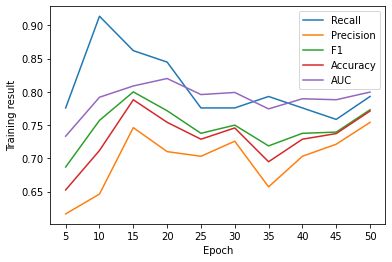

In [ ]:
plt.plot(epochs, rs, label='Recall')
plt.plot(epochs, ps, label='Precision')
plt.plot(epochs, F1s, label='F1')
plt.plot(epochs, accs, label='Accuracy')
plt.plot(epochs, AUCs, label='AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training result')
plt.xticks(epochs)
plt.savefig('validation_performance.png')
plt.show()

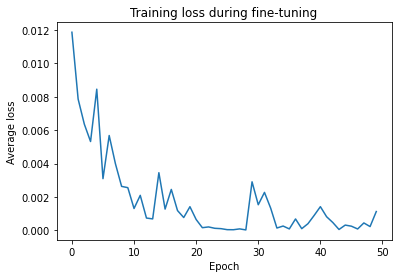

In [ ]:
plt.plot(range(train_epochs_start, train_epochs_end), avg_losses)
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.title('Training loss during fine-tuning')
plt.savefig('fine-tuning_loss.png')
plt.show()

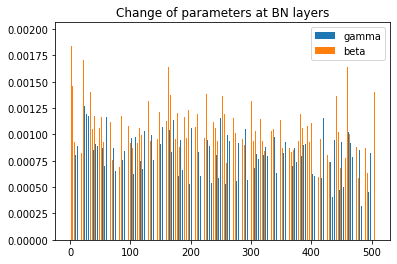

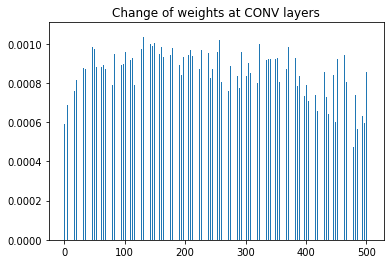

In [ ]:
plot_change(model.cpu(), model_old)
model = model.cuda()

In [ ]:
bs = 10

        
targetlist, scorelist, predlist = predict('test')
        
TP = ((predlist == 1) & (targetlist == 1)).sum()
TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
r = TP / (TP + FN)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
AUC = roc_auc_score(targetlist, scorelist)

print('Testing, average recall: {:.4f}, average precision: {:.4f}, average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}\n'.format(
    r, p, F1, acc, AUC
))
f = open('model_result/test_{}.txt'.format(modelname), 'a+')
f.write('Testing, average recall: {:.4f}, average precision: {:.4f}, average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}\n'.format(
    r, p, F1, acc, AUC
))
f.close()

TP= 94 TN= 53 FN= 11 FP= 45
TP+FP 139
Testing, average recall: 0.8952, average precision: 0.6763, average F1: 0.7705, average accuracy: 0.7241, average AUC: 0.7923



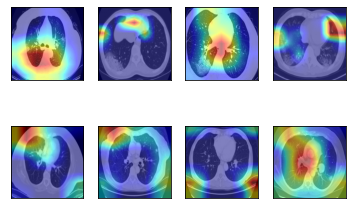

In [ ]:
model = model.cpu()
fig, axes = plt.subplots(2, 4)
negatives = 0
positives = 0
for i in range(len(testset)):
    if negatives == 4 and positives == 4:
        break
    image, label = testset[i]['img'], testset[i]['label']
    if label == 0 and negatives < 4:
        gradcam(model, image, detransformer, label, axes[0][negatives])
        negatives = negatives + 1
    elif label == 1 and positives < 4:
        gradcam(model, image, detransformer, label, axes[1][positives])
        positives = positives + 1

fig.savefig('gradcam.png')
fig.show()

In [ ]:
torch.save(model.state_dict(), 'fine-tune.pt')